In [1]:
import time
import numpy as np
import pandas as pd
import hydroeval as he
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './CFE')
import bmi_cfe_open
import bmi_cfe_enkf_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI

sys.path.append('../USGS/USGS_BMI_FT')
import bmi_usgs

In [2]:
print(bmi_cfe_open)
print(bmi_cfe_enkf_peturb)

print(Bmi_da_ENKF_forSBMI)
print(bmi_usgs)

<module 'bmi_cfe_open' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_open.py'>
<module 'bmi_cfe_enkf_peturb' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_enkf_peturb.py'>
<module 'Bmi_da_ENKF_forSBMI' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./Assimilation\\Bmi_da_ENKF_forSBMI.py'>
<module 'bmi_usgs' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\../USGS/USGS_BMI_FT\\bmi_usgs.py'>


In [3]:
## Open BMI's for each file
#cfe_open = bmi_cfe_open.BMI_CFE()
cfe_open = bmi_cfe_enkf_peturb.BMI_CFE() #One BMI to rule them all
cfe_usgs = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()
usgs = bmi_usgs.BMI_USGS()

In [4]:
## Initialize the BMI's
#cfe_open.initialize(cfg_file='./CFE/cat_58_config_cfe.json')
#cfe_peturbed.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
#cfe_analysis.initialize(cfg_file='./CFE/cat_58_config_cfe.json') # I am confused what this config file should look like

# ## Case study files
cfe_open.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')
cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')
cfe_analysis.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')

cfe_usgs.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')

enkf.initialize(cfg_file='./Assimilation/EnKF_config.json') # Need to create this still
usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config.json')

initialized 84.21526
                         Date     Flow  validity
0   2017-05-15 04:00:00+00:00  166.500       1.0
1   2017-05-15 05:00:00+00:00  161.000       1.0
2   2017-05-15 06:00:00+00:00  156.750       1.0
3   2017-05-15 07:00:00+00:00  151.500       1.0
4   2017-05-15 08:00:00+00:00  148.750       1.0
..                        ...      ...       ...
763 2017-06-15 23:00:00+00:00   28.400       1.0
764 2017-06-16 00:00:00+00:00   28.175       1.0
765 2017-06-16 01:00:00+00:00   28.400       1.0
766 2017-06-16 02:00:00+00:00   27.500       1.0
767 2017-06-16 03:00:00+00:00   27.500       1.0

[768 rows x 3 columns]
USGS station ID 01123000


                time  APCP_surface  RAINRATE      T2D       Q2D     U2D  \
0     5/15/2017 0:00           0.0       0.0  284.078  0.006616  6.0804   
1     5/15/2017 1:00           0.0       0.0  283.180  0.006650  6.0304   
2     5/15/2017 2:00           0.0       0.0  282.440  0.006614  5.9856   
3     5/15/2017 3:00           0.0       0.0  281.662  0.006476  5.9402   
4     5/15/2017 4:00           0.0       0.0  281.702  0.006530  6.3688   
..               ...           ...       ...      ...       ...     ...   
763  6/15/2017 19:00           0.0       0.0  295.270  0.007334 -1.1600   
764  6/15/2017 20:00           0.0       0.0  294.610  0.006788 -1.2230   
765  6/15/2017 21:00           0.0       0.0  293.624  0.006776 -1.2812   
766  6/15/2017 22:00           0.0       0.0  292.722  0.006714 -1.5682   
767  6/15/2017 23:00           0.0       0.0  291.554  0.006650 -1.8486   

        V2D       PSFC   SWDOWN   LWDOWN  
0   -1.9670   98376.98    0.000  318.822  
1   -2.0740  

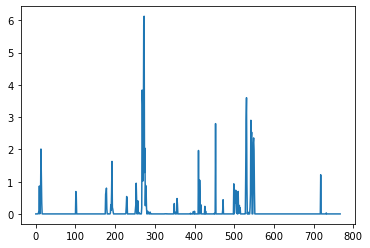

In [5]:
with open(cfe_open.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)
plt.plot(df_forcing['APCP_surface'])

values = df_forcing['APCP_surface']
print(values)

In [6]:
#Make empty matrices for plotting
cfeOpen = []
cfePeturbed = []
cfeAnalysis = []
cfeEnKF = []
cfeUSGS = []

## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['APCP_surface']): #i is RAINRATE

    # Set values for each model
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
#     cfe_usgs.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*1.5)
    
    # Update usgs data and get value to put into EnKF
    usgs.update()
    obs = np.array(usgs.get_value('Flow')) #need array for EnKf function. should get this when initialize. CFS 
    #outflow_error = np.array(cfe_open.get_value('land_surface_water__runoff_depth') + abs(np.random.randn()))
    #cfeUSGS.append(outflow_error)
    #print("CFE USGS", obs)
    
    # Update CFE open and peturbed. Get value for peturbed stats
#     cfe_usgs.update()
    cfe_open.update()
    cfe_peturbed.update()
    
    # Get state vars from Peturbed. These are values as enkf uses
    soil_storage_avail = cfe_peturbed.get_value('soil_storage_avail_m')
    soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_m')
    surface_runoff = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')
   
    # Get values for plotting
    outflow = cfe_open.get_value('land_surface_water__runoff_depth') #m3/s
    cfeOpen.append(outflow) #for plotting
    
#     outflow_usgs = np.array(cfe_usgs.get_value('land_surface_water__runoff_depth')) #m3/s
#     print("outflow_usgs", outflow_usgs)
#     cfeUSGS.append(outflow_usgs) #for plotting
    
    outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    
    # Get mean and covariance for stats of ensemble runs for EnKF
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    cfePeturbed.append(outflow_peturb_mean) # For plotting
    
    # Set EnKF value to usgs, mean, and covariance. Get value from it then update
    enkf.set_value('soil_storage_avail_m', soil_storage_avail) #setting soil storage in enkf
    enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) #setting soil storage in enkf
    enkf.set_value('surface_runoff_depth_m', surface_runoff) #setting soil storage in enkf
    
    enkf.set_value('x', np.array([outflow_peturb_mean]))
    enkf.set_value('P', np.array([outflow_peturb_covar]))
    enkf.set_value('z', np.array([obs[i]]))
    #enkf.set_value('z', np.array([outflow_usgs]))
    enkf.update()
    
    # For plotting
    outflow_enkf = enkf.get_value('enkf')
    cfeEnKF.append(outflow_enkf)
    
    # Get new EnKF state vars to give back to CFE Analysis
    state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
    state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_m')
    state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')
    
    # Set value for CFE analysis based on the state variable change from the EnKF factor to get true streamflow
    cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage)    
    cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res)  
    cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)
    cfe_analysis.update() #get new streamflow value based on state var change
    
    # For plotting
    outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
    cfeAnalysis.append(outflow_analysis) 
        
    # Get values from new CFE analysis to put back into CFE Peturbed to keep look and EnKF going
    cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
    cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
    cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')
    
    # Set value from CFE analysis state variables back into CFE Peturbed to continue EnKF loop
    cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
    cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
    
# # Finalize models
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
usgs.finalize()
enkf.finalize()

Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [23.26013001]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [38.86897878]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [72.58713098]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [79.29634771]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [71.01557941]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [85.68936555]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [68.80379762]
 warning validity is zero
Beginning-------------------------

Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [46.96108546]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [28.86156311]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [24.693911]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [35.77792159]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [37.41203752]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [31.45776502]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [25.64844507]
 warning validity is zero
Beginning---------------------------

EnKF Code predicted, X Post [29.74813108]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [12.06335354]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [17.2947454]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [16.27641817]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [26.59126512]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [27.38653973]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [17.11376805]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [12.162

Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [133.00305026]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [189.15577863]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [127.97693728]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [127.46687773]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [111.34765712]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [103.10724632]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [138.539896]
 warning validity is zero
Beginning--------------------

C:\Users\zjbut\Documents\GitHub\NextGen---The-Simulators-\Toy_Model\./Assimilation\EnKF.py:66: RuntimeWarning: invalid value encountered in floor_divide
  e.factor=e.res//e.x


 [nan]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [28.84703505]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [nan]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [17.31587049]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [nan]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [14.37975117]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [nan]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [40.24309725]
 warning validity is zero
Beginning----------------

EnKF Code predicted, X Post [40.55527662]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [nan]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [31.14260926]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [nan]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [4.2869891]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [nan]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [26.08378842]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [17.08956768]
 warning validity 

EnKF Code predicted, X Post [15.82417537]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [14.44438038]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [25.13200008]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [15.69362903]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [18.92251995]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [12.83648539]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [16.49146793]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [25.11

Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [97.11312246]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [61.76232232]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [34.58173552]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [66.75765437]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [80.30839515]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [96.52497111]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [98.98141869]
 warning validity is zero
Beginning-------------------------

EnKF Code predicted, X Post [36.53801304]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [27.60709901]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [17.53017167]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [30.6318626]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [37.33780374]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [28.88419975]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [16.66191229]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [20.384

EnKF Code predicted, X Post [17.34202081]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [24.37390769]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [20.41890899]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [15.05819346]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [23.88741247]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [21.40687787]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [13.91191239]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [9.848

Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [11.09659409]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [13.32252558]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [15.32891378]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [16.0206053]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [12.94372952]
 warning validity is zero
Beginning----------------------------
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [16.35650901]
 warning validity is zero

GLOBAL MASS BALANCE
  initial volume:   0.6910
    volume input:  84.4438
   volume output:  84.5703
    final volume:   0.5645
        residual: -2.0339e-13

SCHAAKE MASS 

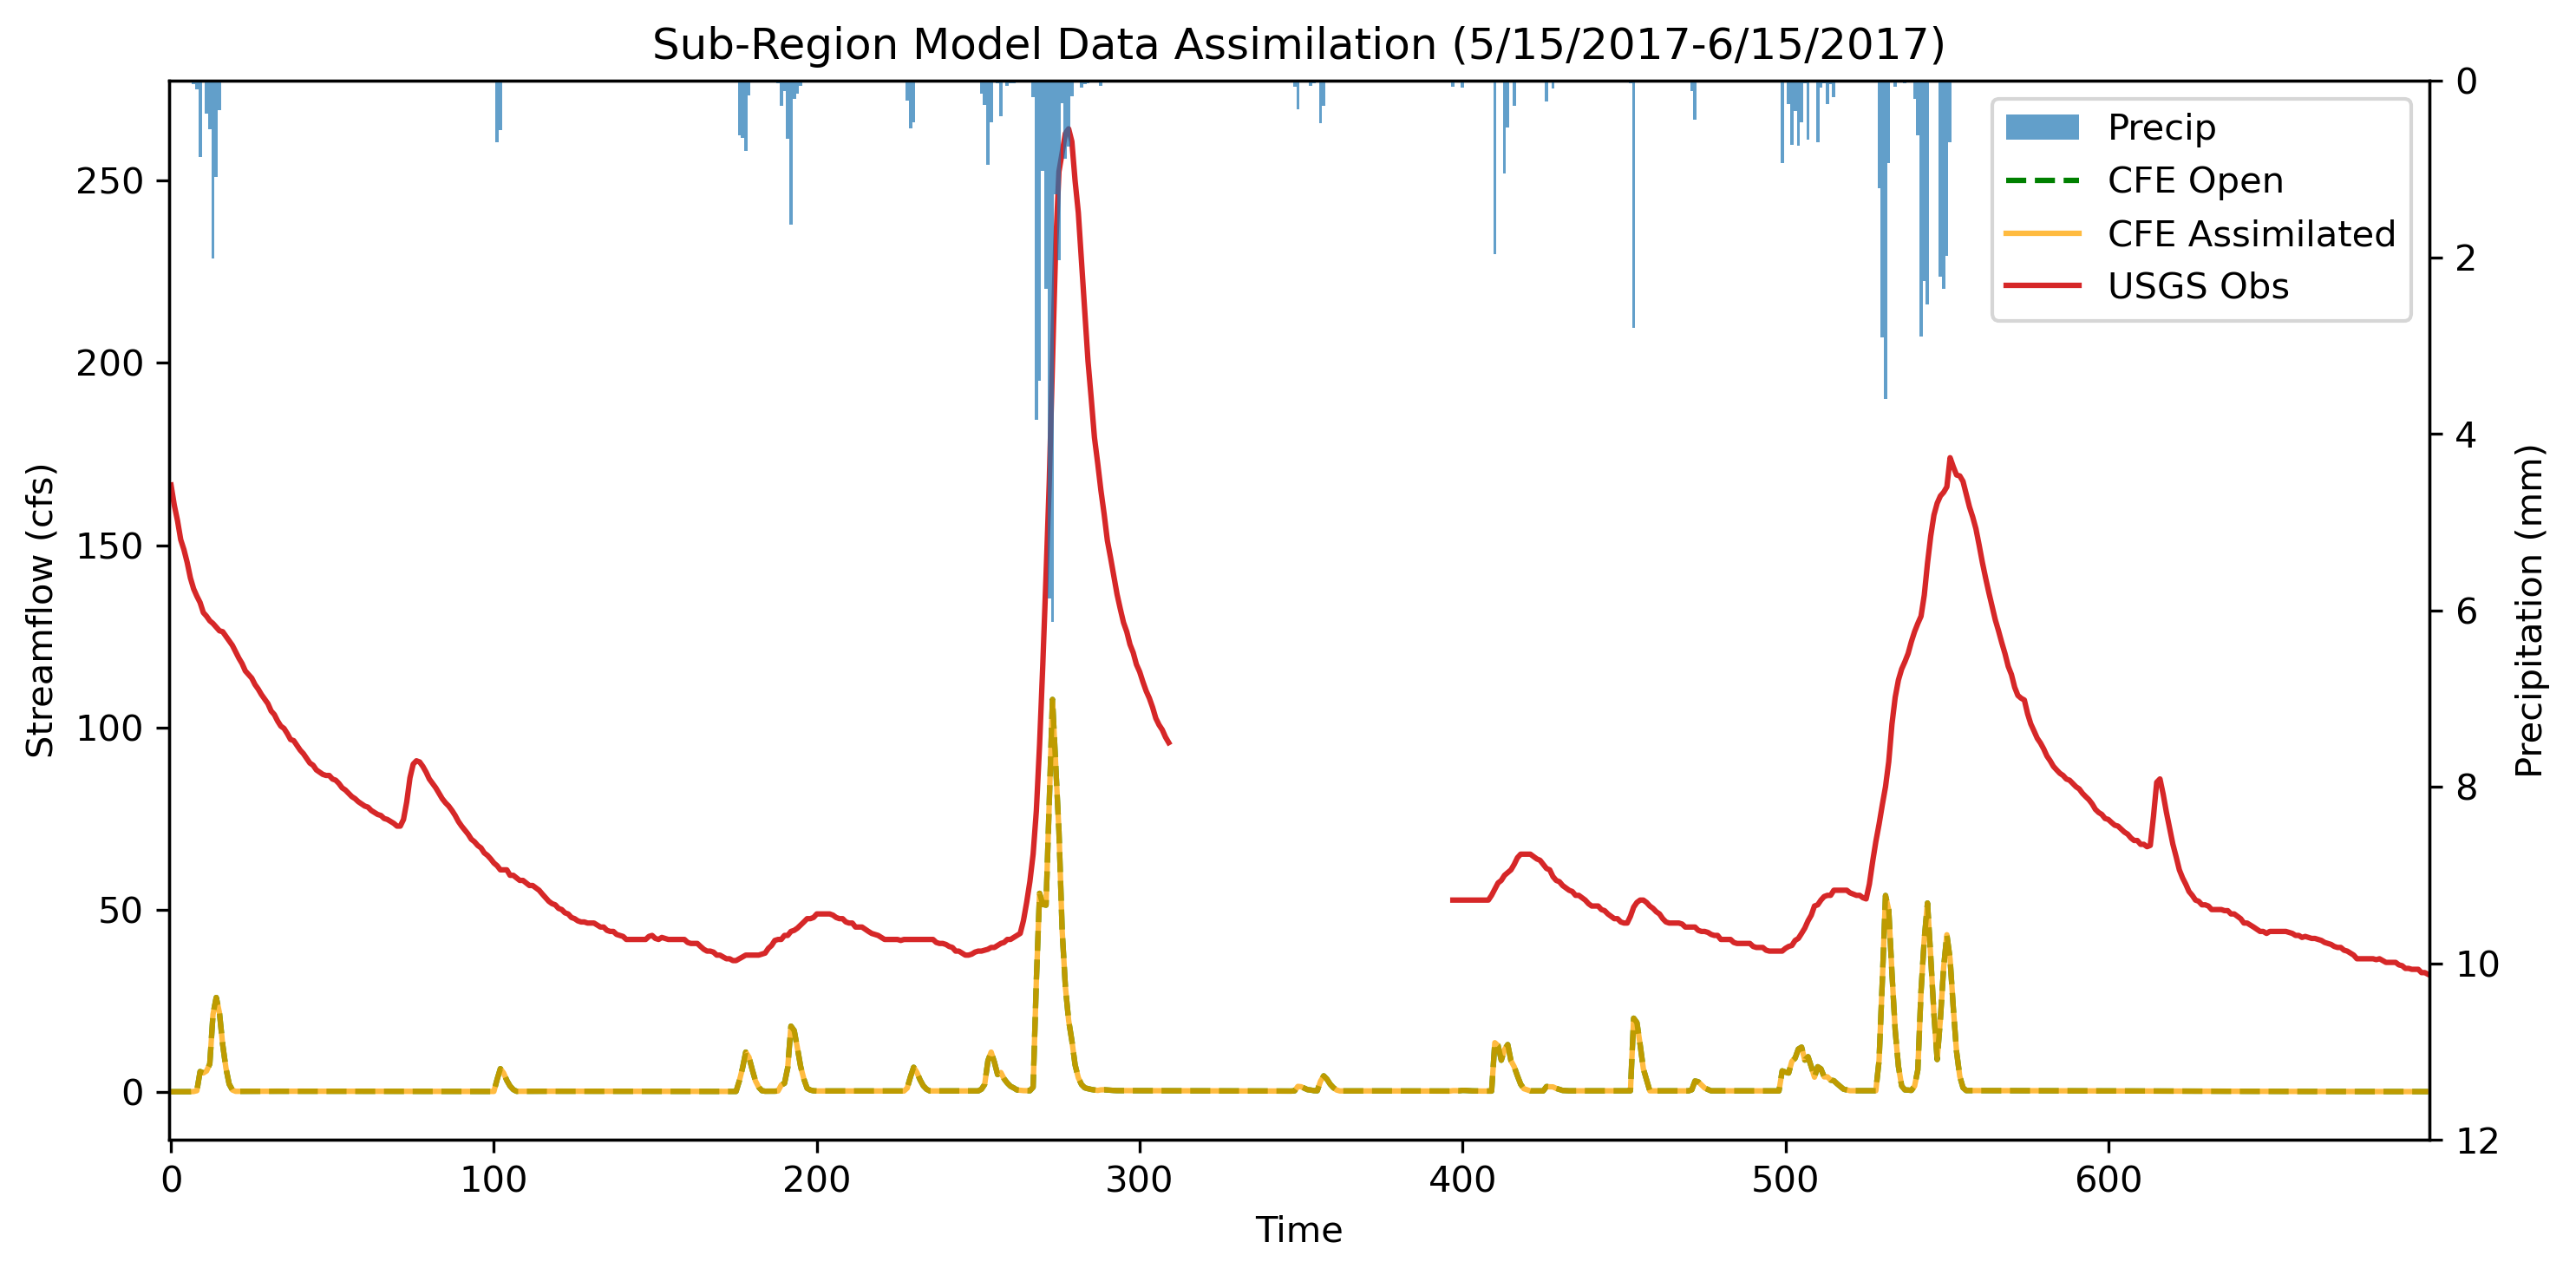

In [7]:
istart_plot=0
iend_plot=700
x = list(range(istart_plot, iend_plot))

fig, ax1 = plt.subplots(figsize = (10,5), dpi=300)

ax2 = ax1.twinx()

ax1.set_xlabel('Time')
ax1.set_ylabel('Streamflow (cfs)')
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(0,12,1)
ax2.invert_yaxis()
#ax1.set_ylim(0,400,1)

plt.title('Sub-Region Model Data Assimilation (5/15/2017-6/15/2017)')
Precip = ax2.bar(x, df_forcing['APCP_surface'][istart_plot:iend_plot],width=1,alpha=0.7, color="tab:blue", label = 'Precip')
#ax1.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
Open, = ax1.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', linestyle='dashed', label = 'CFE Open')
Analysis, = ax1.plot(x, cfeAnalysis[istart_plot:iend_plot], color = 'orange', alpha=0.75, label = 'CFE Assimilated')
Obs, = ax1.plot(x, obs[istart_plot:iend_plot], color = 'tab:red', label = 'USGS Obs')
#Obs, = ax1.plot(x, cfeUSGS[istart_plot:iend_plot], color = 'tab:red', linestyle='dashed',label = 'USGS Obs')


plt.legend(handles = [Precip,Open,Analysis,Obs], loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))

#plt.savefig("WorkingDA_7-19.png")
fig.tight_layout()
ax1.margins(x=0)

plt.show()


In [8]:
df=pd.DataFrame({"obs":obs,"cfeAnalysis":cfeAnalysis,"cfeOpen":cfeOpen})
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,obs,cfeAnalysis,cfeOpen
0,166.500,0.018655,0.018655
1,161.000,0.021563,0.021563
2,156.750,0.024276,0.024276
3,151.500,0.026798,0.026798
4,148.750,0.029136,0.029136
...,...,...,...
719,28.400,0.091561,0.091561
720,28.175,0.090991,0.090991
721,28.400,0.090404,0.090404
722,27.500,0.089800,0.089800


In [9]:
# CFE open eval
nse_open=he.evaluator(he.nse,df["obs"],df["cfeOpen"])
pbias=he.evaluator(he.pbias,df["obs"],df["cfeOpen"])
kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, df["obs"],df["cfeOpen"])
print("r_open=",r_open[0])
print("KGE_open=",kge_open[0])
print("NSE_open=", nse_open[0])
print("PBias=", pbias[0])

# CFE Analysis
nse_analysis=he.evaluator(he.nse,df["obs"],df["cfeAnalysis"])
pbias_analysis=he.evaluator(he.pbias,df["obs"],df["cfeAnalysis"])
kge_analysis, r_analysis, alpha_analysis, beta_analysis = he.evaluator(he.kge, df["obs"],df["cfeAnalysis"])
print("r_analysis=",r_analysis[0])
print("KGE_analysis=",kge_analysis[0])
print("NSE_analysis=", nse_analysis[0])
print("PBias=", pbias_analysis[0])

print("mean_obs=",np.mean(df["obs"]))
print("STD_obs=",np.std(df["obs"]))
print("mean_open=",np.mean(df["cfeOpen"]))
print("STD_open=",np.std(df["cfeOpen"]))
print("mean_analysis=",np.mean(df["cfeAnalysis"]))
print("STD_analysis=",np.std(df["cfeAnalysis"]))

r_open= 0.41925141584600917
KGE_open= -23.001441754847335
NSE_open= -60.30734886122457
PBias= -2377.2037194320797
r_analysis= 0.41925141584600917
KGE_analysis= -23.001441754847335
NSE_analysis= -60.30734886122457
PBias= -2377.2037194320797
mean_obs= 66.93546270718221
STD_obs= 40.45261101684418
mean_open= 2.7020572503632385
STD_open= 9.497769973505365
mean_analysis= 2.7020572503632385
STD_analysis= 9.497769973505365
